In [56]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных

# Простая схема с перекачкой

![Схема НРС](imgs/pump_to_pump_2_nozzles.png)

Схема НРС состоит из:
* 2 источников в виде насоса ПА, соединенных последовательно
* 1 магистральной рукавной линии
* 2 рабочих рукавных линий
* 2 приборов подачи воды

In [57]:
# Вычисляем проводимость насадка для ствола Б
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleB

# Создаем элементы НРС
pump1 = Element('Н1', e_type=0, H_add=20)                                 # Стартовый напор на насосе = 20м    
pump2 = Element('Н2', e_type=1, H_add=20)

hoseM1 = Element('МРЛ1', e_type=1, s=NRS_Data.ss["77"], n=4, l=20)
hoseW1 = Element('РРЛ1', e_type=1, s=NRS_Data.ss["51"], n=3, l=20)
hoseW2 = Element('РРЛ2', e_type=1, s=NRS_Data.ss["51"], n=6, l=20)

nozzle1 = Element('Ств1', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)
nozzle2 = Element('Ств2', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)

# Соединяем элементы друг с другом:
pump1.append(hoseM1).append(pump2)
pump2.append(hoseW1).append(nozzle1)
pump2.append(hoseW2).append(nozzle2)

# Без наблюдателей

# Строим модель и инициируем обозревателей
model1 = NRS_Model('Простая модель от одного насоса к двум стволам, с перекачкой')
# model.build(pump1, interpretate=False);
model1.build(pump1, interpretate=True)

# Печатаем состав модели
NRS_Revision.print_model_elements(model1)

Новый элемент НРС: Н1
Новый элемент НРС: Н2
Новый элемент НРС: МРЛ1
Новый элемент НРС: РРЛ1
Новый элемент НРС: РРЛ2
Новый элемент НРС: Ств1
Новый элемент НРС: Ств2
Новая модель: Простая модель от одного насоса к двум стволам, с перекачкой
all:
  Н1
  МРЛ1
  Н2
  РРЛ1
  Ств1
  РРЛ2
  Ств2
in:
  Н1
out:
  Ств1
  Ств2


In [58]:
# Рассчет 
model1.calc(accuracy=0.05)
print(model1.summaryQ())

Расчет НРС не возможен
6.552530741280176


In [61]:
NRS_Revision.print_element_state(pump2)

elements_next: [<nrs.Element object at 0x000001D87A8B68D0>, <nrs.Element object at 0x000001D87A6C9250>]
elements_previous: [<nrs.Element object at 0x000001D87A9000D0>]
type: 1
name: Н2
q: 6.552530741280176
s: 0
H_in: 17.444403938764626
h: 0.0
z: 0
p: 1
n: 1
q_out: <function q_out_simple at 0x000001D8766E7A60>
H_add: 20
observer: None
l: 0
H_out: 37.44440393876462


In [62]:
print(model1.summaryQ())

pump2.set_H_add(40)
model1.calc(accuracy=0.005)

print(model1.summaryQ())

6.552530741280176
8.010999932976922


In [63]:
hoseM1.n = 5
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 8
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 11
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 14
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 17
model1.calc(accuracy=0.005)
print(model1.summaryQ())

7.949194926322782
7.767235796493592
7.597977324345875
7.436205769252888
7.289298522659095


In [6]:
hoseM1.n = 2
model1.calc(accuracy=0.005)
print(model1.summaryQ())

8.1449313174344


In [7]:
# Исправляет перегрев модели, сбрасывая входящие напоры. Для много стартовых моделей неприемлемо, скорее всего.
pump1.set_H_in(20)

In [8]:
model1.build(pump1, interpretate=True)

# Схема со слиянием нескольких элементов в одну линию


![Схема НРС](imgs/2_pump_to_1_nozzle.png)

Схема НРС состоит из:
* 2 источников в виде насоса ПА
* 2 магистральных рукавных линий
* 1 рабочей рукавной линии
* 1 прибора подачи воды

In [9]:
# Вычисляем проводимость насадка для ствола Б
p_nozzleL = NRS_Revision.calc_p(20, 60)
print(f'Проводимость лафетного ствола {p_nozzleL}')

# Создаем элементы НРС
pump1 = Element('Н1', e_type=0, H_add=80)                                 
pump2 = Element('Н2', e_type=0, H_add=80)

hoseM1 = Element('МРЛ1', e_type=1, s=NRS_Data.ss["77"], n=8, l=20)
hoseM2 = Element('МРЛ2', e_type=1, s=NRS_Data.ss["77"], n=4, l=20)
hoseW1 = Element('РРЛ1', e_type=1, s=NRS_Data.ss["77"], n=4, l=20)

joiner1 = Element('ВС1', 1)

nozzle1 = Element('Ств1', e_type=2, p=p_nozzleL, q_out = q_out_nozzle)

# Соединяем элементы друг с другом:
pump1.append(hoseM1).append(joiner1)
pump2.append(hoseM2).append(joiner1).append(hoseW1).append(nozzle1)

# Без наблюдателей

# Строим модель и инициируем обозревателей
model2 = NRS_Model('Сложная модель со слиянием нескольких элементов в одну линию')
# model.build(pump1, interpretate=False);
model2.build(pump1, interpretate=True)

# Печатаем состав модели
NRS_Revision.print_model_elements(model2)

Проводимость лафетного ствола 2.581988897471611
Новый элемент НРС: Н1
Новый элемент НРС: Н2
Новый элемент НРС: МРЛ1
Новый элемент НРС: МРЛ2
Новый элемент НРС: РРЛ1
Новый элемент НРС: ВС1
Новый элемент НРС: Ств1
Новая модель: Сложная модель со слиянием нескольких элементов в одну линию
all:
  Н1
  МРЛ1
  ВС1
  РРЛ1
  Ств1
  МРЛ2
  Н2
in:
  Н1
  Н2
out:
  Ств1


In [10]:
model2.calc(accuracy=0.005)
print(model2.summaryQ())

Расчет НРС не возможен
18.857260790083174


In [11]:
print('Насос №1')
NRS_Revision.print_element_state(pump1, ['H_add', 'q'])
print('Насос №2')
NRS_Revision.print_element_state(pump2, ['H_add', 'q'])

Насос №1
H_add: 80
q: 9.428630395041587
Насос №2
H_add: 80
q: 9.428630395041587


In [12]:
NRS_Revision.print_element_state(hoseM1)

elements_next: [<nrs.Element object at 0x000001D877A76490>]
elements_previous: [<nrs.Element object at 0x000001D877A875D0>]
type: 1
name: МРЛ1
q: 9.428630395041587
s: 0.015
H_in: 80.0
h: 10.6642229296875
z: 0
p: 1
n: 8
q_out: <function q_out_simple at 0x000001D8766E7A60>
H_add: 0
observer: None
l: 20
H_out: 69.3357770703125


In [13]:
NRS_Revision.print_element_state(hoseM2)

elements_next: [<nrs.Element object at 0x000001D877A76490>]
elements_previous: [<nrs.Element object at 0x000001D877A6A5D0>]
type: 1
name: МРЛ2
q: 9.428630395041587
s: 0.015
H_in: 80.0
h: 5.33211146484375
z: 0
p: 1
n: 4
q_out: <function q_out_simple at 0x000001D8766E7A60>
H_add: 0
observer: None
l: 20
H_out: 74.66788853515625


In [14]:
hoseM1.H_in

80.0

In [15]:
# hoseM1.get_h()
NRS_Revision.print_element_state(hoseM1, ['H_add', 'H_out', 'q', 'H_in', 'h'])

H_add: 0
H_out: 69.3357770703125
q: 9.428630395041587
H_in: 80.0
h: 10.6642229296875


In [16]:
print(hoseM1.h + hoseM1.H_in)

90.6642229296875


# Тест рисования графа

Оставлено на будущую работу

In [17]:
import networkx as nx

Расстояние до Ств1 140 м
Расстояние до Ств2 200 м


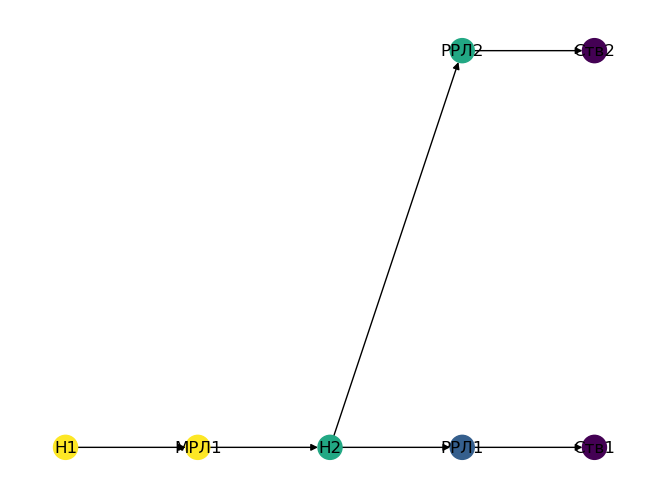

In [54]:
model = model1
# Построение графа НРС
G = nx.DiGraph()
# Узлы - на каждый элемент
for elmnt in model.elmnts:
    G.add_node(elmnt.name, q=elmnt.q)
# Ребра - на каждую связь
for elmnt in model.elmnts:
    for elmnt_next in elmnt.elements_next:
        G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

# Расчет расстояния до элементов
for elmnt in model.elmnts_out:
    paths = nx.shortest_path_length(G, target = elmnt.name, weight='L')
    nx.set_node_attributes(G, paths, 'L')
    print(f'Расстояние до {elmnt.name} {max(paths.values())} м')

# Печать графа НРС
pos={}
pos_list=[]
level=0
for eo in model.elmnts_in:
    v = eo.name
    spl = dict(nx.single_source_shortest_path_length(G, v))
    for nd, p in spl.items():
        if not nd in pos.keys():
            cpos = (p,level)
            # if cpos in pos_list:
            #     cpos = (p,level+1)
            while cpos in pos_list:
                cpos = (p,level+1)
            pos[nd]=cpos
            pos_list.append(cpos)
    level+=1

# nc = [nd[1]['q'] for nd in list(G.nodes(data=True))]
nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
nx.draw(G, pos=pos, with_labels=True, node_color=nc)
plt.show()